## Funciones

In [11]:
## Cargamos los paquetes
#import openpyxl
import requests
import cobra
import os
from cobra.io import read_sbml_model
from cobra.medium import minimal_medium
import warnings
warnings.filterwarnings("ignore")
import json
import pandas as pd
import time
import cometspy as c
import shutil
from cobra import Reaction,Metabolite
from os.path import exists
import os.path
import copy
import cometspy as c
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from pathlib import Path

In [28]:
#La siguiente función descarga el modelo .sbml y lo guarda en una carpeta "modelos_agora", tras lo cual lo carga
#Si el modelo ya está descargado en dicha carpeta, simplemente lo carga
def descargar_leer_agora2(nombre_modelo):
    nombre_modelo = nombre_modelo
    url_padre = "https://www.vmh.life/files/reconstructions/AGORA2/version2.01/sbml_files/individual_reconstructions/"
    url = url_padre + nombre_modelo
    #Directorio donde se guardan los modelos
    nombre_directorio = "modelos_agora"
    directorio_actual = os.getcwd()
    ruta_directorio = os.path.join(directorio_actual, nombre_directorio)
    #Lo creamos si no existe
    if not os.path.exists(ruta_directorio):
        os.makedirs(ruta_directorio)
        models_dir = ruta_directorio
    else:
        models_dir = ruta_directorio
    #Si ya existe el archivo no hace falta descargarlo, se importa directamente
    ruta_archivo = os.path.join(str(models_dir), nombre_modelo)
    if os.path.exists(ruta_archivo):
        model = read_sbml_model(str(ruta_archivo))
        return model 
    #Si no existe se descarga y se importa
    else:
        try:
            # Realizar la solicitud GET a la URL del archivo
            respuesta = requests.get(url)

            # Verificar si la solicitud fue exitosa (código de estado 200)
            if respuesta.status_code == 200:
                # Guardar el archivo localmente
                with open(ruta_archivo, 'wb') as archivo_local:
                    archivo_local.write(respuesta.content)
                #print(f"Archivo descargado exitosamente como '{nombre_modelo}'.")
                #Determinamos el path al archivo
                model = read_sbml_model(str(ruta_archivo))
                return model

            else:
                print(f"Error al descargar el archivo. Código de estado: {respuesta.status_code}")

        except Exception as e:
            print("Error del modelo " + str(nombre_modelo))

## Función que Devuelve una lista de metabolitos de las fuentes de carbono permitidas consumidas por al menos un modelo
def carbon_sources(models, sources=["glucose", "rhamnose", "xylose"]):
    available_sources = []
    for model in models:
        for rxn_id in model.medium.keys():
            rxn = model.reactions.get_by_id(rxn_id)
            met_id = list(rxn.metabolites.keys())[0].id
            met_name = list(rxn.metabolites.keys())[0].name.lower()
            for sugar in sources:
                if sugar in met_name:
                    available_sources.append(met_id)
    return(list(set(available_sources)))

#Función para traducir de "exchange" a metabolito:
def traduc_exchange(exchange):
    met = exchange.replace("EX_", "").replace("(", "[").replace(")","]")
    return met

#Función para definir la concentración de azúcares en el medio dada el porcentaje respectivo a la glucosa
#Devuelve un diccionario con estos valores
#Ajustamos la concentración total a 20 mM
def sugar_levels(glc_D=18.4, xyl_D=11.6, rmn=39.4, gal=0, mnl=0, conc=20):
    sugar_names = ["glc_D", "xyl_D", "rmn", "gal", "mnl"]
    concentraciones = {}
    for name in sugar_names:
        if eval(name) > 0:
            concentraciones[name+"[e]"] = eval(name)
    #Si no suman la concentracion ajustamos
    suma = sum(list(concentraciones.values()))
    ratio = conc/suma
    if suma != conc:
       for azucar, conc in concentraciones.items():
           concentraciones[azucar] = round(conc*ratio, 6)
    
    return concentraciones

#Función para cerrar todos los exchange de un medio:
def close_all_ex(model):
    media_closed = {}
    for reac in model.medium.keys():
        media_closed[reac] = 0
    model.medium = media_closed

#Funcion para abrir exchanges si existen, dado un diccionario con: reaction_id, bound
def open_available_exchanges(model, dicc_exchanges):
    for reac, bound in dicc_exchanges.items():
        if reac in [rx.id for rx in model.reactions]:
            model.reactions.get_by_id(reac).lower_bound = -bound

#Parámetros FLYCOP
def params_flycop(package, globall):
    """Function to initialize the comets' params class
    it can be initialize by submitting two files, one for the package parameters
    and one for the global ones.
    If you don't submit a file, the params class will be initialize with the values stated below
    which have been tested in this simulation"""
    
    if package and globall is not None:
        params = c.params(global_params = globall, package_params= package)
    elif package is not None:
        params = c.params(package_params=package)
    elif globall is not None:
        params = c.params(global_params=globall)
        
    else:
        params = c.params()
        params.all_params['maxCycles']=500
        params.all_params['timeStep']=0.1
        params.all_params['spaceWidth']=0.05
        params.all_params['allowCellOverlap']= True
        params.all_params['cellSize'] = 4.3e-13
        params.all_params['deathRate']= 0.00
        params.all_params['dilFactor'] = 1e-2
        params.all_params['dilTime'] = 12
        params.all_params['numRunThreads']= 8
        params.all_params['maxSpaceBiomass']= 1000
        params.all_params['defaultVmax']= 20
        params.all_params['defaultKm']= 0.01
        params.all_params['defaultHill']= 1
        params.all_params['showCycleTime']= True
        params.all_params['geneFractionalCost']= 0
        params.all_params['writeTotalBiomassLog']= True
        params.all_params['writeMediaLog']= True
        params.all_params['writeFluxLog']= True
        params.all_params['useLogNameTimeStamp']= False
        params.all_params['flowDiffRate']= 1e-7
        params.all_params['growthDiffRate']=1e-7
        params.all_params['FluxLogRate']= 1
        params.all_params['MediaLogRate']= 1
        params.all_params['numExRxnSubsteps']= 12
        params.all_params['geneFractionalCost'] = 0
        params.all_params['exchangestyle']= 'Standard FBA'
        params.all_params['biomassMotionStyle']= 'Diffusion 2D(Crank-Nicolson)'
        params.all_params['mutRate'] = 1e-9
        params.all_params['addRate'] = 1e-9
        params.all_params['minSpaceBiomass'] = 1e-10
    
    return params

#Parámetros normales
def params_normal():
    params = c.params()
    params.all_params['allowCellOverlap']= True
    params.all_params['maxSpaceBiomass']= 1000
    params.all_params['writeMediaLog']=True
    params.all_params['MediaLogRate'] = 1
    params.all_params['maxCycles']=300
    return params

def find_end_cycle(simulation_output):
    # it finish when the strains stop the growth
    end_cycle=0
    counter=0
    for index,row in simulation_output.iterrows():
        new_biomasses=row.iloc[1:]
        if index==0 or index==1:
            old_biomasses=row.iloc[1:]
        else:
            result=new_biomasses.subtract(old_biomasses)
            is_growing=result.apply(lambda x: x>0)
            old_biomasses=new_biomasses
            if is_growing.any()==False:
                counter=counter+1
                if counter==10:
                    break
        end_cycle=index
    return(end_cycle)

# Abrir el archivo JSON y cargar el contenido en un diccionario
with open('Medio_RQ.json', 'r') as archivo:
    medio_general = json.load(archivo)

#Función para generar:
#1. Un .txt que contiene para cada ciclo (hasta el máximo) la biomasa de las cepas y la concentración de los metabolitos de interés
#2. Una representación gráfica de lo anterior en .pdf (cada ciclo se considera 1/10 de hora)
def make_df_and_graph(strains, metabolites, comets, max_cycles):
    '''This function creates a figure and saves it to pdf format.
    It also creates the file biomass_vs_met.txt which contais the quantity
    of each strain and metabolite and has the following columns:
    time(h), strain1 ... strainX, met1 ... metX.'''
    file_name='_'.join(strains)
    df = comets.media #We get the media composition results'
    df_media=copy.deepcopy(df.loc[df['cycle']<max_cycles])
    df2=comets.total_biomass #We get the biomass results
    df_biomass=copy.deepcopy(df2.loc[df2['cycle']<max_cycles])
    columns=['cycle']
    for i in range(0,len(strains)):
        columns.append(strains[i])
    df_biomass.columns=columns
    
    """For each metabolite a column with all zeros is added to the dataframe and each row that contains a value
     (metabolite concentration)is changed in the dataframe"""
    for d in metabolites:
        columns.append(d)
        met =df_media.loc[df_media['metabolite'] == d]

        temp=np.zeros(max_cycles) #Create an array with all zeros
        df_biomass[d]=temp #We added it to the dataframe
        j=1
        while j < (max_cycles): #For each cycle
            if (met.cycle==j).any(): #If the row exists
                df_biomass.loc[j-1,d] = float(met[met['cycle']==j]['conc_mmol']) #Its dataframe value is changed
            j+=1
    df_biomass.columns=columns
    #np.savetxt(r'biomass_vs_'+file_name+'_template.txt', df_biomass.values, fmt='%s',delimiter='\t',header='\t'.join(columns)) #The data is saved
    
    #Only select sugars whose concentration varies
    for source in metabolites:
        if df_biomass[source][0] - df_biomass[source][len(df_biomass[source])-2] < 0.01:
            #print(source)
            metabolites.remove(source)

    #---Starting the figure 
    fig, ax = plt.subplots()

    ax.set_xlabel('Tiempo (h)')
    ax.set_ylabel('Biomasa (g/L)')
    c=['g', 'b', 'r', 'orange', 'pink', 'grey']
    j=0
    lines_strains = []
    df_biomass["total"] = 0 #Columna del total de biomasa
    for i in strains:
        lines_strains.append(ax.plot(df_biomass['cycle']*0.1, df_biomass[i], label=" ".join(i.split("_")[:2]), color=c[j]))
        df_biomass["total"] += df_biomass[i]
        j+=1
    #Añadimos la biomasa total si numero cepas > 1
    if len(strains)>1:
        lines_strains.append(ax.plot(df_biomass['cycle']*0.1, df_biomass["total"], label="Biomasa total", color="black"))

    lines_strains = [elemento for sublist in lines_strains for elemento in sublist] #Unlist
    ax2 = ax.twinx()
    ax2.set_ylabel('Concentración de azúcares (mM)')

    #Dictionary to change sugar id to name
    sugar_id_name = {
        "rmn[e]":"Ramnosa",
        "xyl_D[e]":"Xilosa",
        "glc_D[e]":"Glucosa"
    }

    #Dictionary to always use the same colors:
    sugar_id_color = {
        "rmn[e]":4,
        "xyl_D[e]":5,
        "glc_D[e]":3
    }

    lines_met = []
    for m in metabolites:
        lines_met.append(ax2.plot(df_biomass['cycle']*0.1, df_biomass[m], label=sugar_id_name[m], color=c[sugar_id_color[m]], linestyle='--'))
    lines_met = [elemento for sublist in lines_met for elemento in sublist] #Unlist

    #Leyendas
    font_italic = FontProperties()
    font_italic.set_style('italic')

    font_normal = FontProperties()
    font_normal.set_style('normal')

    # Crear una sola leyenda combinada
    lines = lines_strains + lines_met
    len_lines = len(lines)
    labels = [line.get_label() for line in lines]

    # Crear leyenda general
    legend = plt.legend(lines, labels, loc='upper right', prop=font_normal, ncol=1)

    # Obtener las etiquetas de la leyenda y asignarles el estilo de fuente adecuado
    for text, font in zip(legend.get_texts(), [font_italic] * len(strains) + [font_normal] * (len_lines-len(strains))):
        text.set_fontproperties(font)

    #Ponemos título si solo hay un organismo
    if len(strains) == 1:
        titulo = " ".join(strains[0].split("_")[:2])
        ax.set_title(titulo, loc='center', fontstyle='italic', fontsize=14)
    
    #saving the figure to a pdf
    namedir = "./Finales/"
    plt.savefig(namedir+file_name+'_plot.jpg', format='jpg', dpi = 600)
    plt.show()
    
    return df_biomass

# Función para crear un layout de COMETS con las concentraciones de matbolitos adecuadas
# Añadimos también los modelos, ajustando sus bounds
def plot_growth(model_names, biomasses, medio, modo="n"):
    #Determinamos las strains
    strains = []
    for modelo in model_names:
        strains.append(modelo.replace("xml",""))
    
    #Cargamos los modelos:
    models = [descargar_leer_agora2(name) for name in model_names]

    #Creamos el layout
    ly = c.layout()
    #Añadimos el medio
    medio_cobra = medio
    media_dict = {}
    for ex_id, bound in medio_cobra.items():
        met = traduc_exchange(ex_id)
        media_dict[met] = 1.5
    #Actualizamos el valor de los azúcares
    for met_id, value in sugar_levels().items():
        media_dict[met_id] = value
    
    for met, cant in media_dict.items():
        ly.set_specific_metabolite(met, cant)
    #Añadimos el peptidoglicano
    ly.set_specific_metabolite("PGPm1[c]", 100)
    #print(ly.media)
    
    #Añadimos los modelos
    for model, biomass in zip(models, biomasses):
        new_model = None
        with model as m:
            #Cerramos las exchange
            close_all_ex(model)
            #Abrimos los exchange que existan con el bound adecuado
            open_available_exchanges(model, medio_cobra)
            new_model = model.copy()
        model_added = c.model(new_model)
        model_added.initial_pop=[0,0,biomass]
        ly.add_model(model_added)
        
    #Parámetros
    if modo=="n":
        params = params_normal()
    else:
        params_package=None
        params_global=None
        params = params_flycop(params_package, params_global)

    #Fuentes de carbono comunes
    metabolites = carbon_sources(models)
    
    #Simulación de COMETS
    comets = c.comets(ly,params)
    comets.run()

    #Ciclo límite
    if modo=="n":
        max_cycles = 300
    else:
        max_cycles =find_end_cycle(comets.total_biomass)

    #Gráficos
    df = make_df_and_graph(strains=strains, metabolites=metabolites, comets=comets,max_cycles=max_cycles)
    return df



## Gráficas individuales

In [13]:
def candidate_models(file_path):
    with open(file_path, 'r') as archivo:
        lineas = archivo.readlines()
    candidates = []
    for line in lineas:
        model_name = line.replace("\n","")
        candidates.append(model_name)
    return candidates

In [14]:
lista_candidatos= candidate_models("candidate_models.txt")
with open('Organismos_biomasas.json', 'r') as f:
    organism_biomass = json.load(f)

lista=[]
for organism, data in organism_biomass.items():
    biomass = data[0]
    if biomass>0.45:
        for name in lista_candidatos:
            if "_"+organism.split(" ")[1]+"_" in name:
                lista.append(name)

In [15]:
lista

['Bacillus_amyloliquefaciens_subsp_amyloliquefaciens_DC_12.xml',
 'Bifidobacterium_longum_subsp_longum_NCIMB8809.xml',
 'Bacillus_mojavensis_RO_H_1.xml',
 'Bacillus_atrophaeus_UCMB_5137.xml',
 'Bacillus_velezensis_UCMB5036.xml',
 'Bifidobacterium_adolescentis_L2_32.xml',
 'Geobacillus_stearothermophilus_ATCC_7953.xml',
 'Bacillus_vallismortis_DV1_F_3.xml',
 'Hafnia_alvei_HUMV_5920.xml',
 'Bacillus_pumilus_TUAT1.xml',
 'Leuconostoc_mesenteroides_subsp_mesenteroides_J18.xml',
 'Leuconostoc_pseudomesenteroides_ERR2221296.xml']

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpicadotp6.lp
Reading time = 0.02 seconds
: 1258 rows, 3024 columns, 13092 nonzeros

Running COMETS simulation ...
Done!


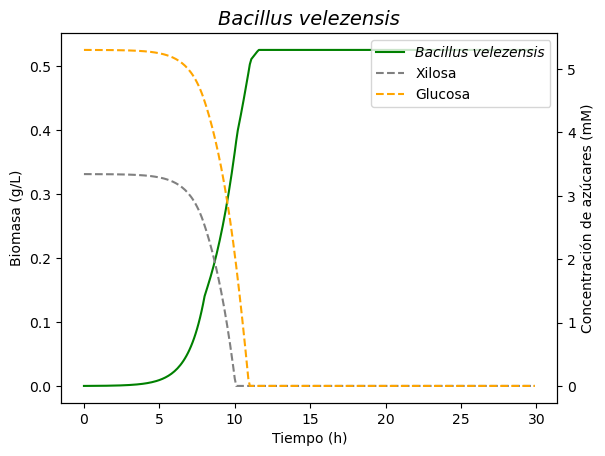

,cycle,Bacillus_velezensis_UCMB5036.,xyl_D[e],glc_D[e],total
0,0,0.000100,3.342889,5.302544,0.000100
1,1,0.000109,3.342834,5.302489,0.000109
2,2,0.000120,3.342774,5.302429,0.000120
3,3,0.000131,3.342709,5.302364,0.000131
4,4,0.000144,3.342637,5.302292,0.000144
...,...,...,...,...,...
295,295,0.525234,0.000000,0.000000,0.525234
296,296,0.525234,0.000000,0.000000,0.525234
297,297,0.525234,0.000000,0.000000,0.525234
298,298,0.525234,0.000000,0.000000,0.525234


In [29]:
plot_growth([lista[4]], biomasses=[0.0001], medio=medio_general)

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmp8e8uoap0.lp
Reading time = 0.05 seconds
: 1348 rows, 3288 columns, 14260 nonzeros

Running COMETS simulation ...
Done!


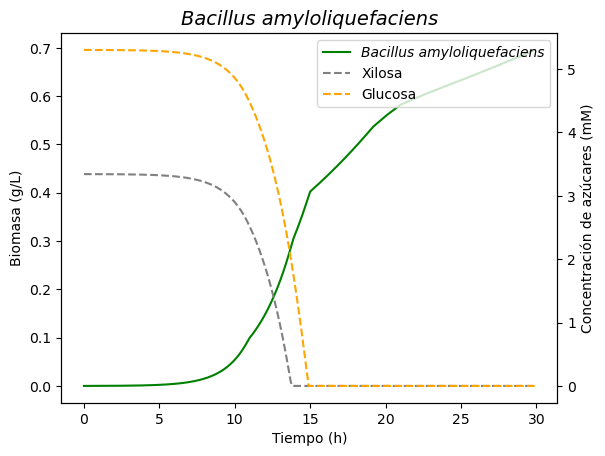

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpirtfg4ux.lp
Reading time = 0.02 seconds
: 996 rows, 2198 columns, 9266 nonzeros

Running COMETS simulation ...
Done!


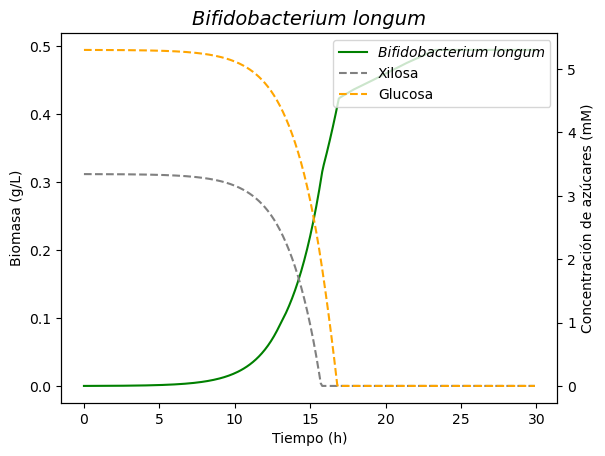

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpd9zx50sx.lp
Reading time = 0.05 seconds
: 1401 rows, 3482 columns, 14996 nonzeros

Running COMETS simulation ...
Done!


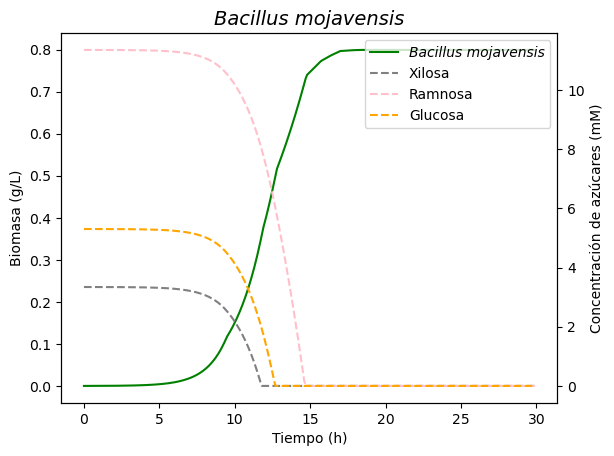

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmp75i951m0.lp
Reading time = 0.03 seconds
: 1754 rows, 3834 columns, 16586 nonzeros

Running COMETS simulation ...
Done!


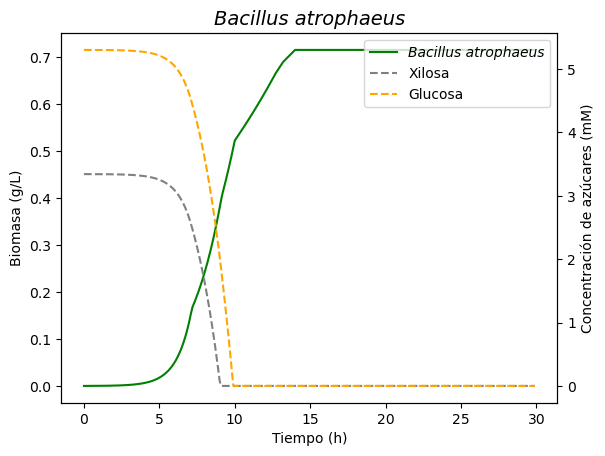

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpykwx7ezc.lp
Reading time = 0.02 seconds
: 1258 rows, 3024 columns, 13092 nonzeros

Running COMETS simulation ...
Done!


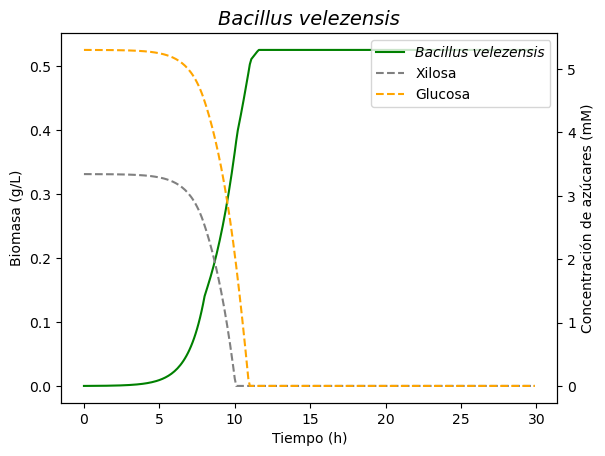

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpf__ln739.lp
Reading time = 0.01 seconds
: 1316 rows, 2674 columns, 11294 nonzeros

Running COMETS simulation ...
Done!


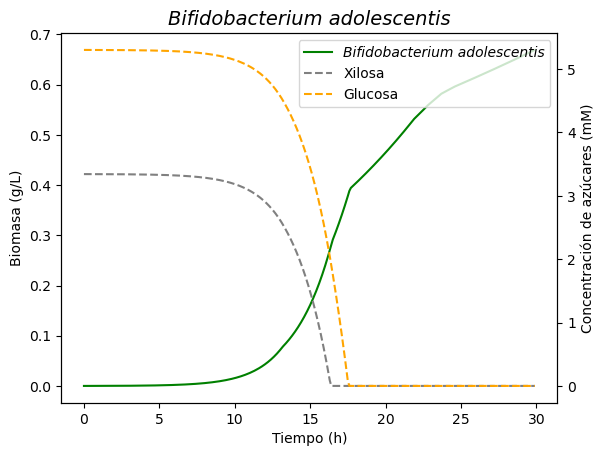

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmp7ra9f97r.lp
Reading time = 0.02 seconds
: 1203 rows, 2766 columns, 12138 nonzeros

Running COMETS simulation ...
Done!


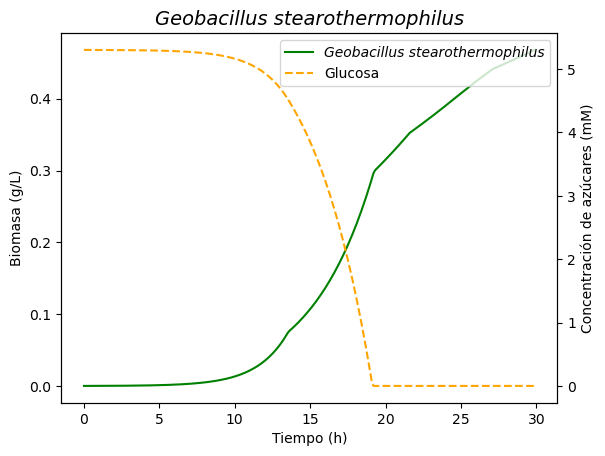

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpy71l4a23.lp
Reading time = 0.04 seconds
: 1352 rows, 3258 columns, 13960 nonzeros

Running COMETS simulation ...
Done!


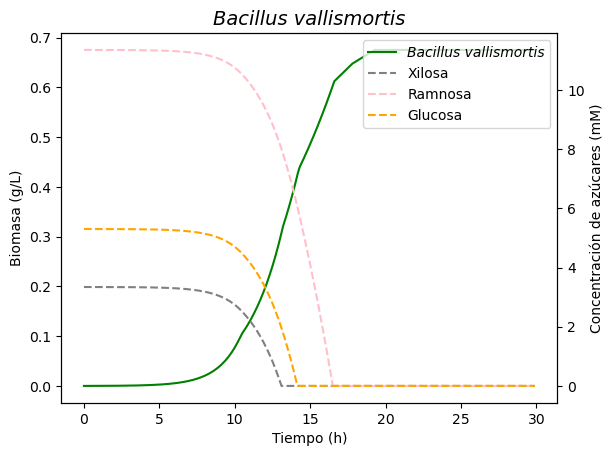

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmp399qigq3.lp
Reading time = 0.02 seconds
: 1413 rows, 3356 columns, 13858 nonzeros

Running COMETS simulation ...
Done!


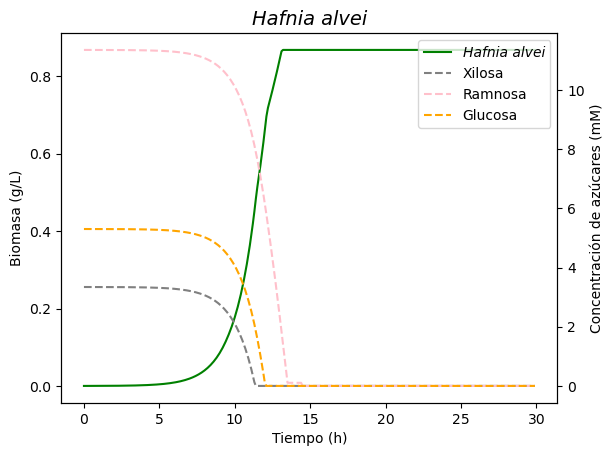

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpha7g7tj3.lp
Reading time = 0.02 seconds
: 1194 rows, 2834 columns, 12522 nonzeros

Running COMETS simulation ...
Done!


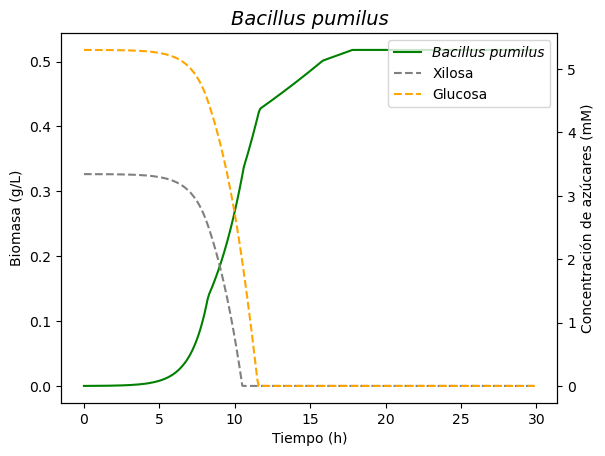

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpl72ki1xv.lp
Reading time = 0.10 seconds
: 1378 rows, 2754 columns, 11912 nonzeros

Running COMETS simulation ...
Done!


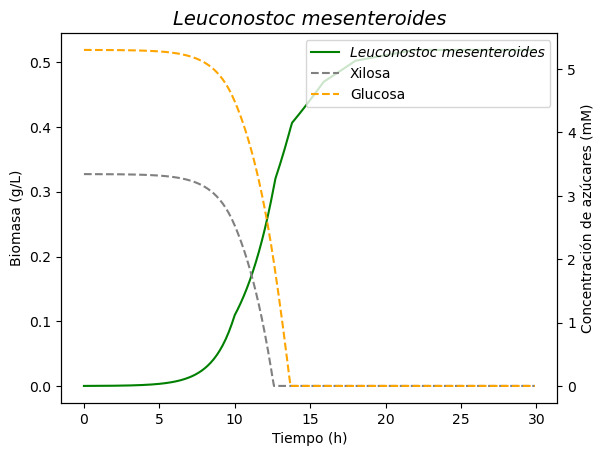

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpbv7yv0xi.lp
Reading time = 0.02 seconds
: 928 rows, 2016 columns, 8680 nonzeros

Running COMETS simulation ...
Done!


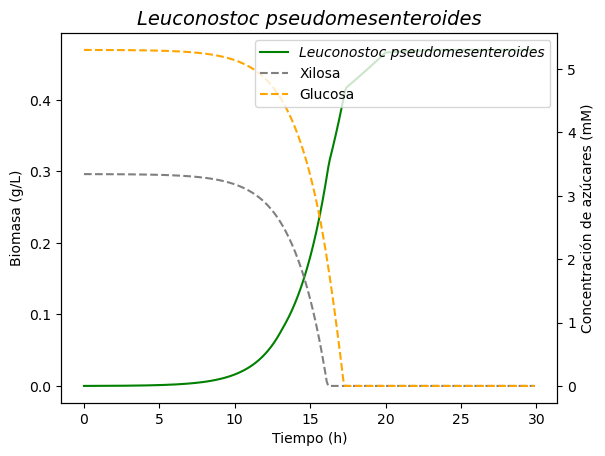

In [30]:
for model_name in lista:
    plot_growth([model_name], biomasses=[0.0001], medio=medio_general)

building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpskmxaa_o.lp
Reading time = 0.03 seconds
: 1316 rows, 2674 columns, 11294 nonzeros

Running COMETS simulation ...
Done!
rmn[e]


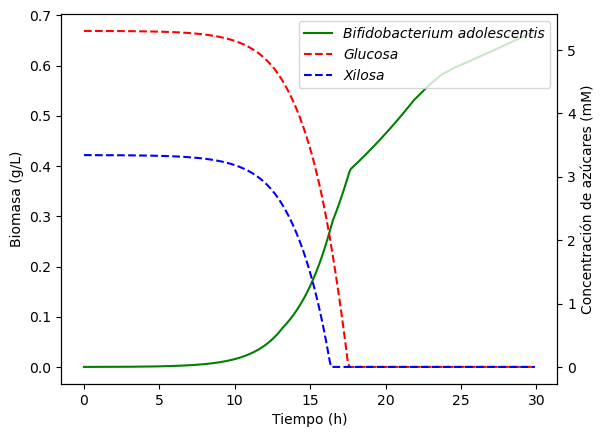

In [42]:
plot_growth(['Bifidobacterium_adolescentis_L2_32.xml'], biomasses=[0.0001], medio=medio_general)

## Gráficas FLYCOP

Consorcio binario:

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-12
building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpzkgdkiqs.lp
Reading time = 0.02 seconds
: 1413 rows, 3356 columns, 13858 nonzeros
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpkb99mklm.lp
Reading time = 0.02 seconds
: 1316 rows, 2674 columns, 11294 nonzeros

Running COMETS simulation ...
Done!


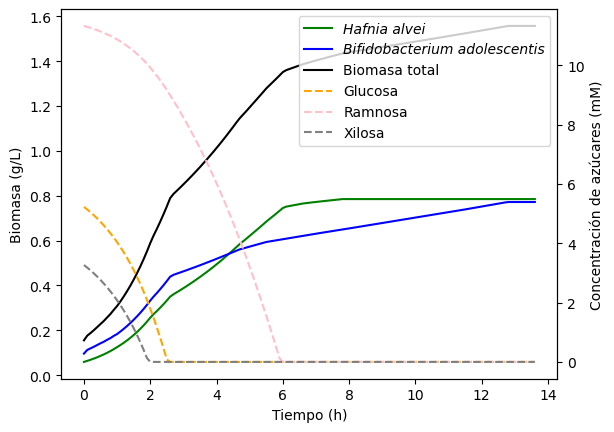

,cycle,Hafnia_alvei_HUMV_5920.,Bifidobacterium_adolescentis_L2_32.,glc_D[e],rmn[e],xyl_D[e],total
0,0,0.059098,0.096243,5.224923,11.324918,3.265268,0.155342
1,1,0.063699,0.112500,5.136824,11.293068,3.177169,0.176199
2,2,0.068658,0.119434,5.042778,11.258740,3.083123,0.188091
3,3,0.074002,0.126795,4.942379,11.221739,2.982724,0.200797
4,4,0.079763,0.134610,4.835193,11.181857,2.875538,0.214373
...,...,...,...,...,...,...,...
132,132,0.785289,0.772176,0.000000,0.000000,0.000000,1.557465
133,133,0.785289,0.772176,0.000000,0.000000,0.000000,1.557465
134,134,0.785289,0.772176,0.000000,0.000000,0.000000,1.557465
135,135,0.785289,0.772176,0.000000,0.000000,0.000000,1.557465


In [3]:
plot_growth(["Hafnia_alvei_HUMV_5920.xml","Bifidobacterium_adolescentis_L2_32.xml"], biomasses=[0.059098212093311564,0.09624343407125435], medio=medio_general, modo="f")

Consorcio de 3:

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-12
building empty layout model
models will need to be added with layout.add_model()
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpa4ajsmro.lp
Reading time = 0.02 seconds
: 1316 rows, 2674 columns, 11294 nonzeros
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpnj5c_izp.lp
Reading time = 0.04 seconds
: 1413 rows, 3356 columns, 13858 nonzeros
Read LP format model from file C:\Users\rqr20\AppData\Local\Temp\tmpeb9rcvm2.lp
Reading time = 0.04 seconds
: 928 rows, 2016 columns, 8680 nonzeros

Running COMETS simulation ...
Done!


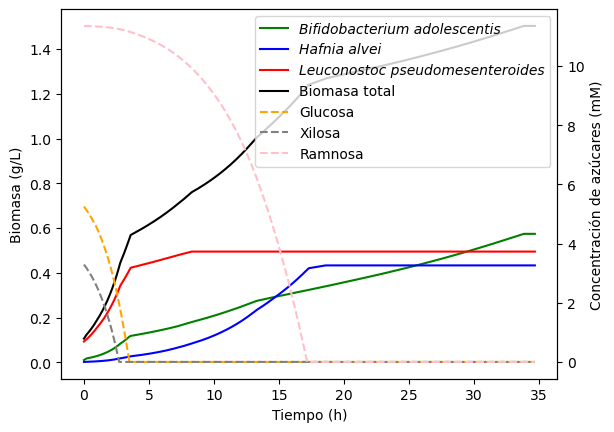

,cycle,Bifidobacterium_adolescentis_L2_32.,Hafnia_alvei_HUMV_5920.,Leuconostoc_pseudomesenteroides_ERR2221296.,glc_D[e],xyl_D[e],rmn[e],total
0,0,0.010710,0.002398,0.093463,5.249309,3.289654,11.353268,0.106571
1,1,0.014137,0.002585,0.098336,5.191779,3.232124,11.351975,0.115059
2,2,0.017841,0.002786,0.103463,5.129734,3.170079,11.350582,0.124091
3,3,0.018941,0.003003,0.108858,5.064332,3.104677,11.349080,0.130803
4,4,0.020108,0.003237,0.114535,4.995392,3.035737,11.347462,0.137880
...,...,...,...,...,...,...,...,...
343,343,0.574302,0.433391,0.495096,0.000000,0.000000,0.000000,1.502788
344,344,0.574302,0.433391,0.495096,0.000000,0.000000,0.000000,1.502788
345,345,0.574302,0.433391,0.495096,0.000000,0.000000,0.000000,1.502788
346,346,0.574302,0.433391,0.495096,0.000000,0.000000,0.000000,1.502788


In [3]:
plot_growth(["Bifidobacterium_adolescentis_L2_32.xml","Hafnia_alvei_HUMV_5920.xml","Leuconostoc_pseudomesenteroides_ERR2221296.xml"], biomasses=[0.01070956657515185,0.0023984534303849504,0.09346258141554882], medio=medio_general, modo="f")